In [ ]:
#1. Download MNIST dataset

#Four files are available on this site, http://yann.lecun.com/exdb/mnist/:

    #train-images-idx3-ubyte.gz: training set images (9912422 bytes)
    #train-labels-idx1-ubyte.gz: training set labels (28881 bytes)
    #t10k-images-idx3-ubyte.gz: test set images (1648877 bytes)
    #t10k-labels-idx1-ubyte.gz: test set labels (4542 bytes)

from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)


In [ ]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [ ]:
#Load Train and Test data into memory

!pip install seaborn==0.9.0

     |████████████████████████████████| 215kB 2.7MB/s 
  Found existing installation: seaborn 0.11.0
    Uninstalling seaborn-0.11.0:
      Successfully uninstalled seaborn-0.11.0


In [ ]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [ ]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')


In [ ]:
#Exploring the Data
print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])
print(train['features'].shape[3]) #60000 examples of images of size 28 x28x 1
print(train['features'][0].shape)
print(train['features'].shape) #(60000, 28, 28, 1)
train['labels'][0]
print(train['features'][0][0][0])



# of training images: 60000
# of test images: 10000
1
(28, 28, 1)
(60000, 28, 28, 1)
[0]


In [ ]:
#Display images
def display_image(position):
   # print(train['features'][position])
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

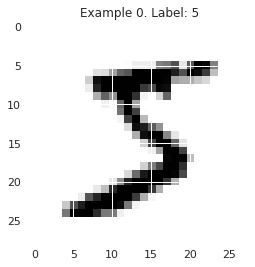

In [ ]:
display_image(0) # 0 to 59,999 examples

In [ ]:
#count of training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [ ]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [ ]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


In [ ]:
#Preparing Input data for Lenet

# Pad images with 0s

train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


In [ ]:
#Lenet model Definition

model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               69240     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
EPOCHS = 10
BATCH_SIZE = 128

In [ ]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)
print(X_train.shape)


(48000, 32, 32, 1)


In [ ]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE  #375
validation_steps = X_validation.shape[0]//BATCH_SIZE #93

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000
Epoch 1/10
375/375 [==============================] - 23s 61ms/step - loss: 0.3014 - accuracy: 0.9180 - val_loss: 0.1029 - val_accuracy: 0.9685
Epoch 2/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0777 - accuracy: 0.9761 - val_loss: 0.0684 - val_accuracy: 0.9793
Epoch 3/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0551 - accuracy: 0.9826 - val_loss: 0.0590 - val_accuracy: 0.9827
Epoch 4/10
375/375 [==============================] - 23s 61ms/step - loss: 0.0414 - accuracy: 0.9873 - val_loss: 0.0540 - val_accuracy: 0.9835
Epoch 5/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0331 - accuracy: 0.9895 - val_loss: 0.0734 - val_accuracy: 0.9797
Epoch 6/10
375/375 [==============================] - 23s 60ms/step - loss: 0.0287 - accuracy: 0.9906 - val_loss: 0.0483 - val_accuracy: 0.9856
Epoch 7/10
375/375 [==============================] - 23s 60ms/step - loss: 0.

In [ ]:
for layer in model.layers:
  g=layer.get_config()
  h=layer.get_weights()
  print (g)
  print (h)


In [ ]:
score = model.evaluate(test['features'], to_categorical(test['labels']))

print('Test loss:', score[0])
print('Test accuracy:', score[1])





313/313 [==============================] - 3s 9ms/step - loss: 0.0595 - accuracy: 0.9831
Test loss: 0.05952128767967224
Test accuracy: 0.9830999970436096


(1, 32, 32, 1)
[5]


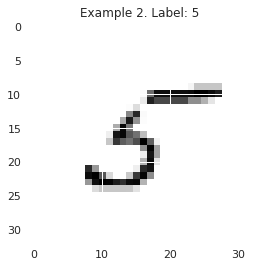

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

display_image(2)
samples_to_predict = np.array(train['features'][2:3])
print(samples_to_predict.shape)

predictions = model.predict(train['features'][2:3])

#print(predictions)

#print(train['labels'][1])

classes = np.argmax(predictions, axis = 1)
#numpy.savetxt('predict.txt', classes, fmt="%d")
print(classes)


In [ ]:
model.save_weights('weights.h5')
model.save('myModel.h5')

In [ ]:
pip install hdfviewer

In [ ]:
%matplotlib ipympl
import numpy
import h5py
from hdfviewer.widgets.HDFViewer import HDFViewer
from hdfviewer.widgets.PathSelector import PathSelector

#path = PathSelector(extensions=[".hdf",".h5",".nxs"])
#path.widget

#if path.file:
#    hdf5 = h5py.File(path.file,"r")
#    display(HDFViewer(hdf5))

hdf5 = h5py.File("/content/weights.h5","r");
display(HDFViewer(hdf5))
hdf5.close

Keylist = list(hdf5.keys())
print(Keylist)

conv2d= hdf5['conv2d']
#print(list(conv2d['conv2d'])) #['bias:0', 'kernel:0']
conv2d_bias = conv2d['conv2d']['bias:0'].value.flatten();
conv2d_kernel = conv2d['conv2d']['kernel:0'].value.flatten()
print(conv2d_kernel)
conv2d_1 = hdf5['conv2d_1']
conv2d_1_bias = conv2d_1['conv2d_1']['bias:0'].value.flatten();
conv2d_1_kernel = conv2d_1['conv2d_1']['kernel:0'].value.flatten()
dense = hdf5['dense']
dense_bias = dense['dense']['bias:0'].value.flatten()
dense_weights = dense['dense']['kernel:0'].value.flatten()
dense_1 = hdf5['dense_1']
dense_1_bias = dense_1['dense_1']['bias:0'].value.flatten()
dense_1_weight = dense_1['dense_1']['kernel:0'].value.flatten()
dense_2 = hdf5['dense_2']
dense_2_bias = dense_2['dense_2']['bias:0'].value.flatten()
dense_2_weight = dense_2['dense_2']['kernel:0'].value.flatten()

numpy.savetxt('Check1.txt', (conv2d_bias,conv2d_kernel), fmt="%s")
numpy.savetxt('LeNet_weights.txt', (conv2d_bias,conv2d_kernel,conv2d_1_bias,conv2d_1_kernel,dense_bias,dense_weights,dense_1_bias,
                            dense_1_weight ,dense_2_bias,dense_2_weight), fmt="%s")



HDFViewer(children=(HDFViewer(children=(Accordion(children=(HTML(value="b'tensorflow'"), HTML(value="b'2.4.0'"…

['average_pooling2d', 'average_pooling2d_1', 'conv2d', 'conv2d_1', 'dense', 'dense_1', 'dense_2', 'flatten']
[-0.00047723  0.2620724   0.2903557   0.12975878  0.01024475  0.0659721
  0.19242178  0.13762642  0.13826178  0.02949963  0.0653324   0.13637038
  0.19824447 -0.30831417 -0.09321295  0.0895093  -0.11955581  0.12227229
 -0.10459551  0.04455205 -0.06264461 -0.22450545 -0.14343219 -0.0669177
 -0.25155222  0.09834089 -0.0810236   0.2696802   0.20648283  0.1787816
 -0.1445253  -0.23335469  0.1476334   0.25074378 -0.02351732 -0.01548421
  0.16299368  0.00978481 -0.20286049  0.17918843  0.27667212 -0.31018412
  0.07532935 -0.14095809 -0.08520913 -0.14829117  0.16518575 -0.16146578
 -0.17941557  0.15782101 -0.08443403  0.17470194 -0.18256155 -0.0783929 ]
